In [1]:
import obspy
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os
import util
from scipy.fft import fft, ifft, fftfreq, rfft
import pickle
from obspy import UTCDateTime
import scipy.signal as signal
from spectrum import *
from pylab import *
import pandas as pd
from obspy.imaging.spectrogram import spectrogram
import random 
from datetime import timedelta

In [2]:
root = '/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3/'

In [3]:
eq_list = os.listdir(root)

client = Client("IRIS")

cat = obspy.read_events('/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3_catalog.xml')

eq_with_data = []
cat_with_data = cat.copy()
cat_with_data.clear()
for event in cat:
    eq_name = util.catEventToFileName(event)
    if os.path.isdir(root+eq_name) and os.path.isdir(root+eq_name+'/station_xml_files') and os.path.exists(root+eq_name+'/picks.pkl'):
        eq_with_data.append(eq_name)
        cat_with_data.extend([event])

do_ypcall: clnt_call: RPC: Timed out
do_ypcall: clnt_call: RPC: Timed out
do_ypcall: clnt_call: RPC: Timed out


In [4]:
binned_spectra = [
    [[],[],[],[]],#0-1
    [[],[],[],[]],#1-2
    [[],[],[],[]],#2-3
    [[],[],[],[]],#3-4
    [[],[],[],[]],#4-5
    [[],[],[],[]],#5-6
    [[],[],[],[]],#6-7
    [[],[],[],[]],#7-8
    [[],[],[],[]]#8-9
]

In [5]:
df =  pd.read_pickle('/home/earthquakes1/homes/Rebecca/phd/seismo_det/dataframe_bandpass_3_0_075Hz.pkl')

# actual spectrograms

In [ ]:
def prep_data(data, tr_no, tr_name):
    pick = UTCDateTime(picks[tr_name])
    start = pick -1 
    end = pick + 5 
    d = data[tr_no].copy()#.filter('lowpass', freq=10)
    d.interpolate(100, 'lanczos', a = 20)
    d.filter('highpass', freq=0.25) #anything less than 0.25s (1/4s) we can't undertand or model, could be aliased.
    d.detrend()
    d.integrate()
    d.detrend()
    d.trim(start, end)
    d.detrend()
    return d

20190131_194949.a
20190131_130953.a
20190131_130350.a
20190131_101656.a
20190131_085520.a


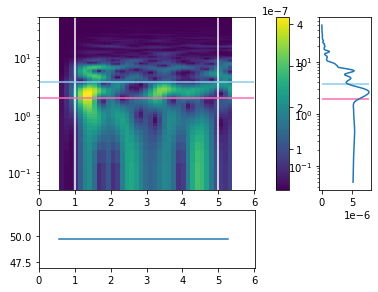

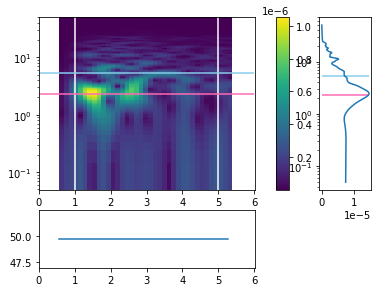

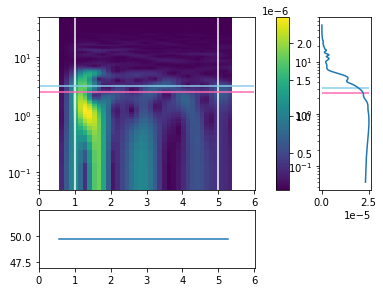

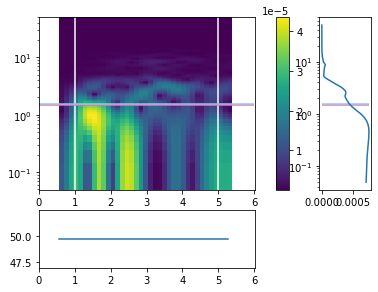

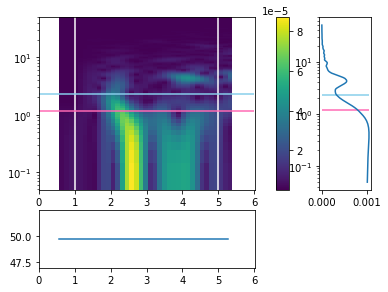

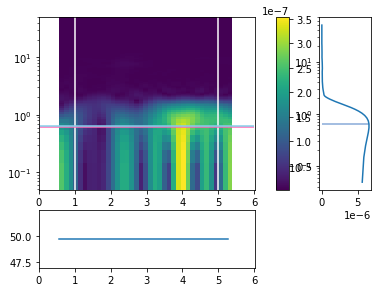

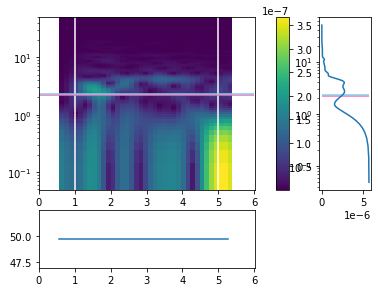

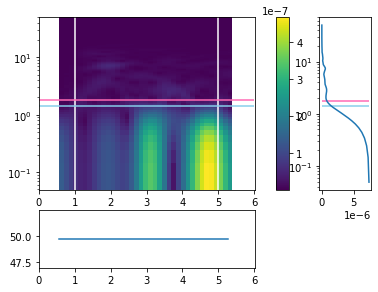

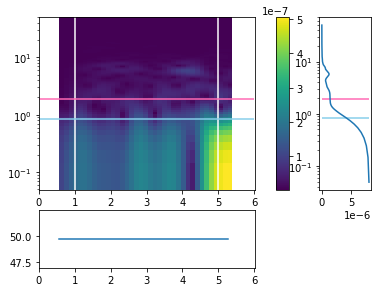

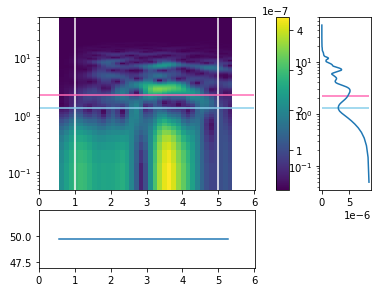

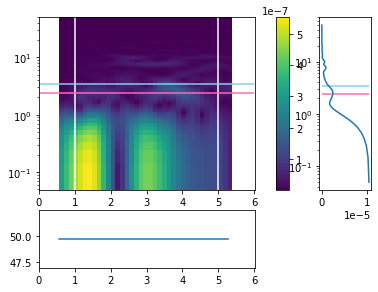

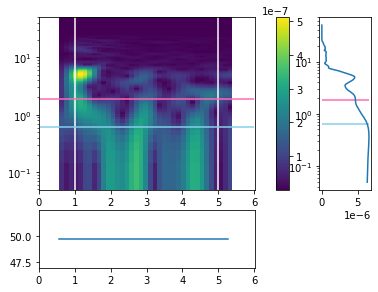

In [21]:

for count in range(0, 5):#len(eq_with_data)):
    eq_no = count #random.randrange(0,len(eq_with_data))
    eq_name = eq_with_data[eq_no]
    Z_comp = 0
    print(eq_name)
    try:
        data = obspy.read(root+eq_name+'/data/*/*')
        inv = obspy.read_inventory(root+eq_name+'/station_xml_files/*')
        data.remove_response(inv)
        with open(root+eq_name+'/picks.pkl', 'rb') as f:
            picks = pickle.load(f)
        df_row = df.loc[eq_name]
    except: 
        continue
    if len(data)>0:
        successful = 0
        date = util.filenameToDate(eq_name)
        filter_start = str(UTCDateTime(date-timedelta(seconds=1)))
        filter_stop = str(UTCDateTime(date+timedelta(seconds=1)))
        event = cat.filter('time > ' + filter_start, 'time < ' + filter_stop)
        data_nearby = util.find_nearby_data(data, inv, event[0], 100)

        for tr_no in range(0, len(data_nearby)):
            sr = data_nearby[tr_no].stats.sampling_rate
            tr_name = data_nearby[tr_no].stats.network+'.'+data_nearby[tr_no].stats.station+'.'+data_nearby[tr_no].stats.location
            
            # only consider vertical stations (Z)
            if data_nearby[tr_no].stats.channel[-1] == 'Z':
                try:
                    tpmax = df_row.tpmax[Z_comp]
                    tc = df_row.tc[Z_comp]
                    
                    d = prep_data(data_nearby, tr_no, tr_name)
                    fig = plt.figure()
                    ax1 = fig.add_axes([0.1, 0.1, 0.5, 0.2]) #[left bottom width height]
                    ax2 = fig.add_axes([0.1, 0.37, 0.5, 0.60], sharex=ax1)
                    ax3 = fig.add_axes([0.65, 0.37, 0.03, 0.6])
                    ax4 = fig.add_axes([0.75, 0.37, 0.12, 0.6])
                                    #make time vector
                    t = np.arange(d.stats.npts) / d.stats.sampling_rate

                    #plot waveform    
                    #ax1.plot(t, d.data, 'k')


                    #plot spectrogram 
                    spl2 = d
                    fig = spl2.spectrogram(show=False, axes=ax2, log = True)
                    mappable = ax2.collections[0]
                    ax2.vlines(1, 0, 50, color='white')
                    ax2.vlines(5, 0, 50, color='white')
                    ax2.hlines(1/tpmax, 0, 6, color='hotpink')
                    ax2.hlines(1/tc, 0, 6, color='skyblue')

                    l = ax2.collections
                    coords = l[0]._coordinates
                    amp = l[0]._A

                    coords_concat = np.array(coords[0][:-1])
                    coords_concat_all = np.array(coords[0][:-1])
                    for i in range(1, len(coords)-1):
                        coords_concat = np.concatenate((coords_concat, coords[i][:-1]))
                    for i in range(1, len(coords)):
                        coords_concat_all = np.concatenate((coords_concat_all, coords[i][:-1]))
                    y = []
                    x = []
                    for j in coords_concat:
                        y.append(j[1])
                        x.append(j[0])
                    y_all = []
                    x_all = []
                    for j in coords_concat_all:
                        y_all.append(j[1])
                        x_all.append(j[0])

                    columns_x = [[] for _ in range(37)]
                    columns_y = [[] for _ in range(37)]
                    columns_amp = [[] for _ in range(37)]
                    columns_y_all = [[] for _ in range(37)]
                    for i in range(0, len(coords_concat)):
                        columns_x[i%37].append(x[i])
                        columns_y[i%37].append(y[i])
                        columns_amp[i%37].append(amp[i])
                    for i in range(0, len(coords_concat_all)):
                        columns_y_all[i%37].append(y_all[i])

                    heights = []
                    for i in range(1, len(columns_y_all[0])):
                        heights.append(log(columns_y_all[0][i])-log(columns_y_all[0][i-1]))

                    rows_x = [[] for _ in range(512)]
                    rows_y = [[] for _ in range(512)]
                    rows_amp = [[] for _ in range(512)]

                    for i in range(0, len(coords_concat)):
                        #print(i)
                        rows_x[i//37].append(x[i])
                        rows_y[i//37].append(y[i])
                        rows_amp[i//37].append(amp[i])

                    ax1.plot(x[0:37], sum(np.array(columns_y_all).transpose()[:-1].transpose()*np.array(heights), 1))
                    ax4.plot(sum(np.array(rows_amp),1), columns_y[0])
                    ax4.hlines(1/tpmax, 0, max(sum(np.array(rows_amp),1)), color='hotpink')
                    ax4.hlines(1/tc, 0, max(sum(np.array(rows_amp),1)), color='skyblue')
                    ax4.set_yscale('log')

                    #ax1.plot(x[0:37], sum(np.array(columns_amp)*np.array(heights[0:512]), 1))
                    #ax4.scatter(sum(np.array(rows_amp), 1), rows_y)
                    #ax4 = ax1.twinx()
                    #ax4.plot(x[0:37], sum(columns_amp, 1), c = 'tab:orange')

                    plt.colorbar(mappable=mappable, cax=ax3)
                    Z_comp += 1
                except:
                    continue #print('except')
                

In [20]:
np.array(columns_y_all).transpose()[:-1].shape

(512, 37)

In [11]:
np.array(columns_y_all).shape

(37, 513)